# Using a Convolutional Neural Network to classify musical instruments

In this colab you will train a model to recognize musical instruments from the `nsynth` database.

In [66]:
import numpy as np
from IPython import display as ipd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds

In [67]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# default nsynth samplerate
sr = 16000
clip_audio_at = sr // 1 # maximum 1 second

# mfcc parameters

window_length = 256
hop_length = 128

num_mels = 20
min_hz = 60.0
max_hz = 6400.0

AUTOTUNE = tf.data.experimental.AUTOTUNE

batch_size = 64
max_x = 32
# train, validation, and test sizes to fetch from the nsynth database
p = [8000, 2000, 200]


## Import the nsynth dataset

Nsynth is a large-scale and high-quality dataset of annotated musical notes: https://magenta.tensorflow.org/datasets/nsynth

In [68]:
label_names = [
               'bass', 'brass', 'flute',
               'guitar', 'keyboard', 'mallet',
               'organ', 'reed', 'string', 'synth_lead', 'vocal'
               ]

### The Nsynth dataset

First, look at the dataset shape and select a percentage of which to use here

In [69]:
nsynth = tfds.load("nsynth", try_gcs=True)
print(f"Nsynth keys: {', '.join(nsynth.keys())}")
for key in nsynth.keys():
    print(f"{key} dataset length: {len(nsynth[key])}")

Nsynth keys: test, train, valid
test dataset length: 4096
train dataset length: 289205
valid dataset length: 12678


In [150]:

train_files = tfds.load("nsynth",split=f"train[:{sum(p)}]",shuffle_files=True, try_gcs=True)
# val_files   = tfds.load("nsynth",split=f"valid[:{p[1]}]",shuffle_files=True, try_gcs=True)
# test_files  = tfds.load("nsynth",split=f"test[:{p[2]}]", shuffle_files=True, try_gcs=True)

print('Training set size', len(train_files))
# print('Validation set size', len(val_files))
# print('Test set size', len(test_files))

Training set size 10200


In [151]:
assert isinstance(train_files, tf.data.Dataset)

## Helper Functions
To make MFCCs in tensorflow 
and to map MFCCs and labels to our nsynth dataset

In [153]:
mel_weights = tf.signal.linear_to_mel_weight_matrix(num_mel_bins=num_mels, 
                                                    num_spectrogram_bins=window_length//2+1, 
                                                    sample_rate=sr,
                                                    lower_edge_hertz=min_hz,
                                                    upper_edge_hertz=max_hz)

In [154]:
def mfcc(waveform):
    # Padding for files with less than clip_audio_at samples
    zero_padding = tf.zeros([clip_audio_at] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate audio with padding 
    # so that all audio clips will be of the same length
    waveform = tf.cast(waveform, tf.float32)
    padded_waveform = tf.concat([waveform, zero_padding], 0)
    # compute stft
    D = tf.signal.stft(padded_waveform, window_length,  hop_length)
    # take absolute for amplitude
    amp_spec = tf.math.abs(D)

    # compute MFCCs
    mfcc_spec = tf.tensordot(amp_spec, mel_weights, 1)
    
    return mfcc_spec

In [155]:
def mfcc_and_label(entry):
    mfcc_spec = mfcc(entry['audio'][:clip_audio_at])
    mfcc_spec = tf.expand_dims(mfcc_spec, -1)
    label = entry['instrument']['family']
    return mfcc_spec, label

## MFCCs and Label Datasets

In [156]:
mfcc_train_ds = train_files.map(mfcc_and_label, num_parallel_calls=AUTOTUNE)
# mfcc_test_ds  = test_files.map( mfcc_and_label, num_parallel_calls=AUTOTUNE)
# mfcc_val_ds   = val_files.map(  mfcc_and_label, num_parallel_calls=AUTOTUNE)

## Plot some elements of the labelled MFCCs

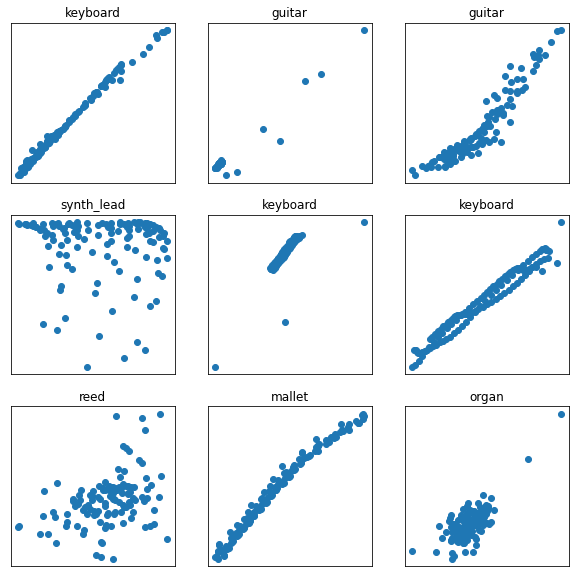

In [157]:
d = 3
scatter_plot = True


fig, axes = plt.subplots(nrows=d, ncols=d, figsize=(10, 10))

for i, (mfcc, label) in enumerate(mfcc_train_ds.take(d*d)):
    r = i // d
    c = i % d
    ax = axes[r][c]
    
    ax.set_title(label_names[label.numpy()])
    
    mfcc = np.log(np.squeeze(mfcc.numpy()))

    if scatter_plot:
        ax.set_yticks([])
        ax.set_xticks([])
        ax.scatter(mfcc[:,0],mfcc[:,1])
    else:
        ax.imshow(mfcc.T, origin='lower', aspect='auto')
        ax.axis('off')

plt.show()
plt.close()

## Normalization Layer

In [158]:
# create a normalizer

normalizer = tf.keras.layers.experimental.preprocessing.Normalization()

# adapt your normalization with the train dataset, 
# but only using the mfccs, not the labels, hence the .map()

normalizer.adapt(mfcc_train_ds.map(lambda x, _: x))



---



# Batch, Cache and Prefetch

We'll make a new dataset that is used for training. This one is different from the Spectrogram and Label datasets, because it is now "batched", or split into groups, and it will be cached in memory for better performance.

Batch the training and validation sets for model training and add dataset [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) operations to reduce read latency while training the model.


In [160]:
train_ds = mfcc_train_ds.take(p[0])
print("Train set size:",len(train_ds))
train_ds = train_ds.batch(batch_size).cache().prefetch(AUTOTUNE)

valid_ds = mfcc_train_ds.skip(p[0]).take(p[1])
print("Validation set size:",len(valid_ds))
valid_ds = valid_ds.batch(batch_size).cache().prefetch(AUTOTUNE)

test_ds  = mfcc_train_ds.skip(p[0]+p[1]).take(p[2])
print("Test set size:",len(test_ds))
test_ds = test_ds.batch(batch_size).cache().prefetch(AUTOTUNE)
# test_ds  = mfcc_test_ds.batch(batch_size).cache().prefetch(AUTOTUNE)
# val_ds   = mfcc_val_ds.batch(batch_size).cache().prefetch(AUTOTUNE)

Train set size: 8000
Validation set size: 2000
Test set size: 200


## Input Shape

In [161]:
for mfcc, _ in mfcc_train_ds.take(1):
  input_shape = mfcc.shape
  print('Input shape:', input_shape)

if input_shape[0] >= max_x:
    resize_x = max_x
else:
    resize_x = input_shape[0]

Input shape: (124, 20, 1)


## Innstantiate the Sequential class with your layers

In [168]:
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.experimental.preprocessing.Resizing(resize_x,num_mels),
    normalizer,
    tf.keras.layers.Conv2D(resize_x, 3),
    tf.keras.layers.LeakyReLU(alpha=0.3),
    tf.keras.layers.Conv2D(resize_x*2, 3),
    tf.keras.layers.LeakyReLU(alpha=0.3),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,
                          kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)), 
    tf.keras.layers.LeakyReLU(alpha=0.4),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_names))
    
    ])

In [169]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_28 (Resizing)       (None, 32, 20, 1)         0         
_________________________________________________________________
normalization_2 (Normalizati (None, 32, 20, 1)         3         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 30, 18, 32)        320       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 30, 18, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 28, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 28, 16, 64)        0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 9, 5, 64)        

## Compile the model

In [170]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


## Train 

In [171]:
history = model.fit(
    train_ds, 
    validation_data=valid_ds,  
    epochs=200, 
    verbose=1,
    callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1, patience=5)
)

Epoch 1/200
125/125 [==============================] - 1s 7ms/step - loss: 2.3393 - accuracy: 0.2428 - val_loss: 1.9487 - val_accuracy: 0.3820
Epoch 2/200
125/125 [==============================] - 1s 5ms/step - loss: 1.9586 - accuracy: 0.3681 - val_loss: 1.7435 - val_accuracy: 0.4425
Epoch 3/200
125/125 [==============================] - 1s 5ms/step - loss: 1.8010 - accuracy: 0.4219 - val_loss: 1.6495 - val_accuracy: 0.4670
Epoch 4/200
125/125 [==============================] - 1s 5ms/step - loss: 1.7133 - accuracy: 0.4419 - val_loss: 1.5810 - val_accuracy: 0.4940
Epoch 5/200
125/125 [==============================] - 1s 5ms/step - loss: 1.6605 - accuracy: 0.4529 - val_loss: 1.5242 - val_accuracy: 0.5065
Epoch 6/200
125/125 [==============================] - 1s 5ms/step - loss: 1.6189 - accuracy: 0.4734 - val_loss: 1.4918 - val_accuracy: 0.5200
Epoch 7/200
125/125 [==============================] - 1s 5ms/step - loss: 1.5809 - accuracy: 0.4907 - val_loss: 1.4868 - val_accuracy: 0.5275

## Plot results

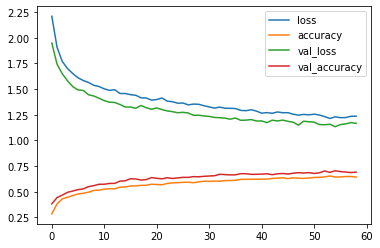

In [172]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'])
plt.plot(history.epoch, metrics['accuracy'])
plt.plot(history.epoch, metrics['val_loss'])
plt.plot(history.epoch, metrics['val_accuracy'])
plt.legend(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
plt.show()


## Confusion matrix

In [174]:
predictions = model.predict(test_ds)
pred_labels = np.array([np.argmax(p) for p in predictions])

In [175]:
pred_labels.shape

(200,)

In [176]:
true_labels = []
for _,label in test_ds.as_numpy_iterator():
    true_labels.append(label)
true_labels = np.concatenate(true_labels)
true_labels.shape

(200,)

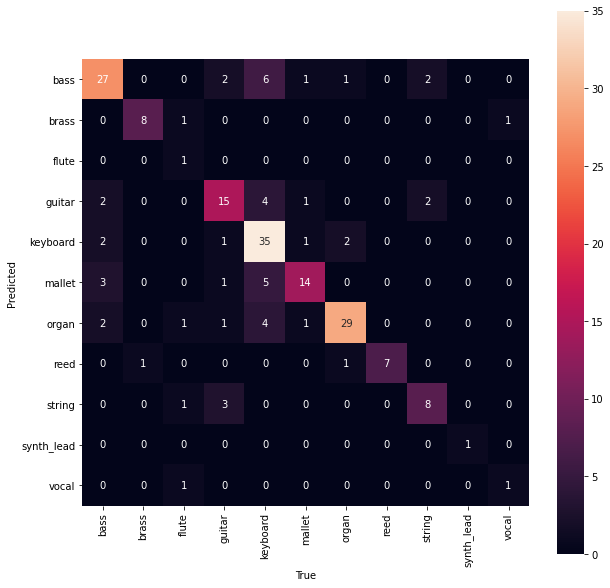

In [177]:
mat = tf.math.confusion_matrix(true_labels, pred_labels)

fig = plt.figure(figsize=(10,10))

sns.heatmap(mat, square=True, annot=True, cbar=True, fmt='d',
            xticklabels=label_names,
            yticklabels=label_names)

plt.xlabel('True')
plt.ylabel('Predicted');

In [179]:
print(f"Actual accuracy is: {metrics['accuracy'][-1]*100}")

Actual accuracy is: 64.31249976158142


## Single Predictions



I've seen a bass.

           Moreover, it is a bass 

             Therefore, 
                         I am 
                                Correct!



Text(0.5, 1.0, 'Predictions for "bass"')

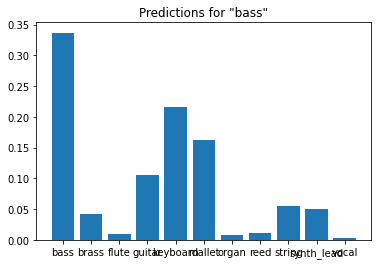

In [187]:
example = mfcc_train_ds.skip(p[0] + p[1]).skip(np.random.randint(p[2]-1)).take(1)

for spec,label in example:
    beast = label_names[int(label.numpy())]

predictions_single = model.predict(example)

cloud = label_names[np.argmax(predictions_single[0])]

if beast != cloud:
    just_silly = "Wrong!"
    somehow="However,"
else:
    just_silly = "Correct!"
    somehow="Moreover,"

print(f"""

I've seen a {cloud}.

           {somehow} it is a {beast} 

             Therefore, 
                         I am 
                                {just_silly}
"""
)


plt.bar(label_names, tf.nn.softmax(predictions_single[0]))
plt.title(f'Predictions for "{predicted_label}"')
